In [16]:
import torch
from src.model_utils import load_model, tokenize_sentence, word2idx, load_word2vec_format, predict_single_text_DE
import torch

In [17]:
model = load_model('DE_best_model')

w2v_model = load_word2vec_format(
        "./NLP_Data/embeddings/GoogleNews-vectors-negative300.bin.gz", binary=True)
embedding_weights = torch.FloatTensor(w2v_model.vectors)
embedding = torch.nn.Embedding.from_pretrained(embedding_weights)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text = "I love this movie. It's the best movie I've ever seen!"

print(predict_single_text_DE(text, model, device=device, embedding=embedding))

1


c:\Users\mario\Desktop\IMAT_ICAI\23_24_TERCERO\2o_CUATRI\PROYECTO_DL_NLP\rnn_explainability\env\lib\site-packages\torch\nn\modules\module.py:1520: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  return forward_call(*args, **kwargs)


In [23]:
def smoothgrad(input_text: str,
               model: torch.nn.Module,
               embedding: torch.nn.Embedding,
               num_samples: int = 50,
               noise_level: float = 0.1,
               device: str = 'cpu') -> torch.Tensor:
    """
    Calculate SmoothGrad for a given input text.

    Args:
        input_text (str): The input text for which to calculate SmoothGrad.
        model (torch.nn.Module): The model used for prediction.
        embedding (torch.nn.Embedding): The embedding layer to be applied to the input texts.
        num_samples (int): Number of noise samples.
        noise_level (float): Level of noise to add to input.
        device (str): The device to run the model on.

    Returns:
        torch.Tensor: SmoothGrad attributions for each token in the input text.
    """

    # Tokenize input 
    tokenized_input = tokenize_sentence(input_text)

    # Convert tokens to indices
    input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)
    
    # Create baseline input
    baseline_indices = torch.zeros_like(input_indices).to(device)
    
    embedding.to(device)

    # Calculate difference between input and baseline embeddings
    input_embedding = embedding(input_indices.to(device)).to(device)
    baseline_embedding = embedding(baseline_indices).to(device)
    diff = input_embedding - baseline_embedding

    # Generate perturbed inputs with noise
    smoothgrad_inputs = []
    for _ in range(num_samples):
        noise = torch.randn_like(input_embedding) * noise_level
        perturbed_input = input_embedding + noise
        smoothgrad_inputs.append(perturbed_input)
    
    smoothgrad_inputs = torch.cat(smoothgrad_inputs, dim=0)

    # Calculate model outputs for perturbed inputs
    smoothgrad_inputs.requires_grad_(True)
    model.to(device)
    model.eval()
    outputs = model(smoothgrad_inputs, torch.tensor([len(tokenized_input)] * num_samples).to(device))

    # Choose the output element to compute gradients with respect to

    # Calculate gradients for the chosen output element
    gradients = torch.autograd.grad(outputs=outputs.sum(), inputs=smoothgrad_inputs)[0]

    # Calculate SmoothGrad (average gradients over noise samples)
    smoothgrad_attributions = torch.mean(gradients, dim=0)

    return smoothgrad_attributions



In [24]:
import torch

# Define a sample input text
input_text =  "I love this movie. It's the best movie I've ever seen!"

# Calculate SmoothGrad attributions
smoothgrad_attributions = smoothgrad(input_text, model.to(device), embedding.to(device), num_samples=50, noise_level=0.1, device='cpu')

# Normalize attributions to [0, 1]
smoothgrad_attributions = torch.abs(smoothgrad_attributions) / torch.max(torch.abs(smoothgrad_attributions))

# Convert input text to tokens
tokenized_input = tokenize_sentence(input_text)

# Sort tokens based on their SmoothGrad attributions (from highest to lowest)
sorted_indices = torch.argsort(smoothgrad_attributions, descending=True)

tokens = []
attributtions = []

# Print tokens along with their SmoothGrad attributions
for i in range(len(tokenized_input)):
    token = tokenized_input[i]
    tokens.append(token)
    token_sg = smoothgrad_attributions[i]
    attributtions.append(token_sg.mean().item())
    print(f"Token: {token} - SmoothGrad Attribution: {token_sg}")

C:\Users\mario\AppData\Local\Temp\ipykernel_26072\3922486003.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_indices = torch.tensor(word2idx(w2v_model, tokenized_input)).unsqueeze(0).to(device)


Token: I - SmoothGrad Attribution: tensor([0.3067, 0.0690, 0.1849, 0.0835, 0.2165, 0.2488, 0.1133, 0.0793, 0.1042,
        0.0637, 0.3861, 0.0359, 0.1918, 0.0621, 0.0351, 0.1608, 0.0419, 0.3476,
        0.1057, 0.2430, 0.0302, 0.0062, 0.0519, 0.3129, 0.2945, 0.1127, 0.0634,
        0.0463, 0.0128, 0.0025, 0.0010, 0.0827, 0.0238, 0.6454, 0.0285, 0.2836,
        0.2369, 0.2799, 0.0200, 0.0941, 0.0060, 0.0500, 0.1286, 0.5921, 0.0421,
        0.4797, 0.3235, 0.0497, 0.1919, 0.2432, 0.7038, 0.2474, 0.0214, 0.3361,
        0.2086, 0.0613, 0.0167, 0.1881, 0.2651, 0.0465, 0.1488, 0.1689, 0.2688,
        0.0689, 0.0637, 0.5238, 0.0034, 0.2749, 0.0918, 0.1952, 0.0031, 0.0635,
        0.2567, 0.0972, 0.2656, 0.0612, 0.0009, 0.1066, 0.1033, 0.1481, 0.2469,
        0.0993, 0.2454, 0.0948, 0.0920, 0.0178, 0.3554, 0.2620, 0.0048, 0.0591,
        0.0697, 0.1977, 0.0952, 0.0765, 0.1601, 0.0532, 0.0182, 0.1681, 0.1252,
        0.7388, 0.5339, 0.1060, 0.2075, 0.1158, 0.4247, 0.1116, 0.2708, 0.0889,
     

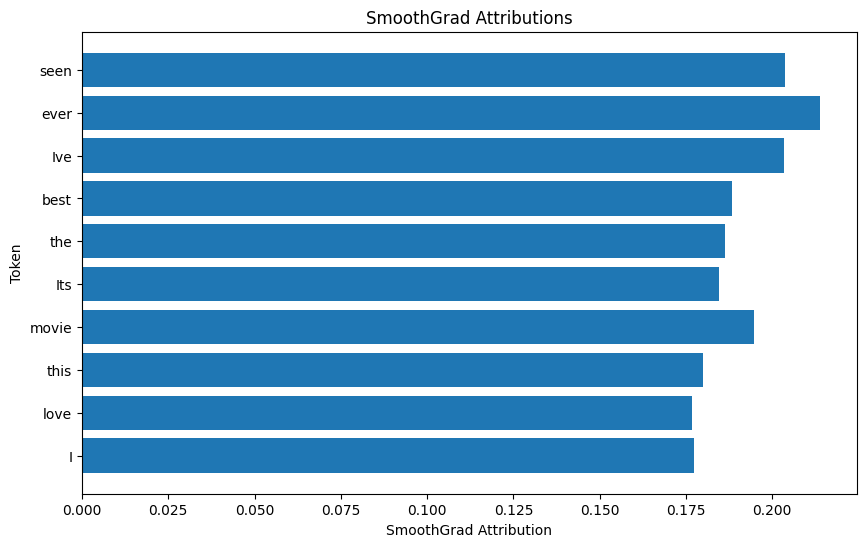

In [25]:
import matplotlib.pyplot as plt

# Plot absolute integrated gradients
plt.figure(figsize=(10, 6))
plt.barh(tokens, attributtions)
plt.xlabel('SmoothGrad Attribution')
plt.ylabel('Token')
plt.title('SmoothGrad Attributions')
plt.show()
